# NLP Analysis of Disasters on Social Media

Youfei Zhang

*2019/01/05*

## 1 Executive Summary

The abundance of social media data has revolutionazed the way we approach big crisis such as earthquake and floods fundamentally. On the personal level, people who are at the frontier of those events take pictures and seek helps on social media right at the spot. On the society level, government and international organization has been trying to utilize those data to make actionable decisions in a timely manner. For instance, by analyzing tweets with searches of "earthquake", the government would be able to gain awareness of the emergencies and the urgent needs of people at different locations, and could allocate resources accordingly. 

However, it is still challenging to analyze social media data with traditional methods. 

## 2 Background




### 2.1 Objective

This project aims to anwer the following questions:

- Identify usedful tweets: given a tweet, can we accurately classify it into a real disaster event from the noise?  
- deploy an efficient method: is it possible to accurately classify events with a fast algorithm? 

Building on this, I employed combinations of dfferent models and feature engineering methods. 


### 2.2 Dataset Description

This dataset is a sample from the [CrisisNLP](http://crisisnlp.qcri.org/lrec2016/lrec2016.html) dataset. It contains 2438 crisis-related Twitter data about events such as floods, earthquake, typhoon. Each tweet is labeled into one of the 5 informative classes by paid workers, with one "not related or irrelevant" class. 

There are noany missing values in this dataset.

In [1]:
# load libaries

import pandas as pd
import numpy as np
import keras
import nltk
import re
import codecs

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# inspect the raw data

raw = pd.read_csv("Desktop/Code/git/NLP-for-disaster-tweets/data/sample.csv")
raw.head()

FileNotFoundError: File b'Desktop/Code/git/NLP-for-disaster-tweets/data/sample.csv' does not exist

In [4]:
# quickly look into the lable values

class_label = raw.label.value_counts().rename('num_class').reset_index()
class_label['Percent'] = (class_label.num_class/raw.shape[0])*100
pd.DataFrame(class_label)

NameError: name 'raw' is not defined

,label,% of Count
Not related or irrelevant,718,29.450369
Other Useful Information,679,27.850697
Donations and volunteering,389,15.955701
Affected individuals,255,10.459393
Infrastructure and utilities,233,9.557014
Sympathy and support,164,6.726825


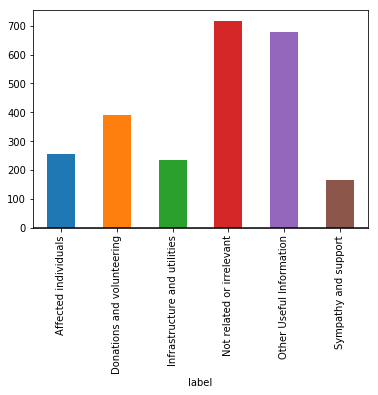

In [29]:
# define a function inspect the distribution of the data

%matplotlib inline
import matplotlib.pyplot as plt

def count_table(df, c):
        count = df[c].value_counts()
        count_percent = 100 * count / len(df)
        count_table = pd.concat([count, count_percent], axis=1)
        
        count_table.columns = [c, '% of Count']
        count_table.round(2)

        gb = df.groupby(df[c])
        targetEDA=gb[c].aggregate(len)
        
        plt.figure()
        targetEDA.plot(kind='bar', grid=False)
        plt.axhline(0, color='k')
        
        return count_table

count_table(raw, 'label')

As we can see from the plot, 'Not related or irrelevant' is the most frequent class. 

## 3 Data Preprocessing

The item columns contains the raw tweets posted by the users. We need to clean and tokenize these tweets to abstract useful information. 

### 3.1 Data Cleaning

The cleaning steps is as following: 

1. normalizing to utf8 
2. lowercasing 
2. Digit -> DDD 
3. URLs -> httpAddress 
4. @username -> userID 
5. Remove special characters, keep ; . ! ? 
6. normalize elongation 

In [58]:
import re, os
import string 
import twokenize
from collections import defaultdict
import codecs
import unicodedata

In [99]:
# build a container to process the data 

columns = defaultdict(list) # each value in each column is appended to a list

with open("Desktop/Code/git/big-crisis-data/data/sample.csv", newline='') as f:
    reader = csv.DictReader(f) # read rows into a dictionary format
    for row in reader: # read a row as {column1: value1, column2: value2,...}
        for (k,v) in row.items(): # go over each column name and value 
            columns[k.strip()].append(v) # append the value into the appropriate list based on column name k

In [130]:
# define a function to clean the item column 

def clean_text(lst):
    clean_tweet = []
    for tweet in lst:
        print ("[original]", tweet)

        # 1. normalizing utf8 formatting 
        tweet = tweet.encode("utf8").decode("utf8")
#         tweet = tweet.encode("ascii","ignore")
        tweet = tweet.strip(' \t\n\r')
    
        # 2. lowering case 
        tweet = re.sub(' +', ' ', tweet)
        tweet = tweet.lower()
        print ("[lowercase]", tweet)

        # 3. normalizing digits
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word.isdigit()]:
            tweet = tweet.replace(word, "D" * len(word))
        print ("[digits]", tweet)
        
        # 4. normalizing urls
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if '/' in word or '.' in word and len(word) > 3]:
            tweet = tweet.replace(word, "httpAddress")
        print ("[urls]", tweet)
        
        #5. username 
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word[0] == '@' and len(word) > 1]:
            tweet = tweet.replace(word, "usrId")
        print ("[username]", tweet)
        
        # 6. special characters
        punc = '@$%^&*()_+-={}[]:"|\'\~`<>/,'
        trans = str.maketrans(punc, ' '*len(punc))
        tweet = tweet.translate(trans)
        print ("[punctuation]", tweet)
        
        # 7. Normalizing +2 elongated char
        tweet = re.sub(r"(.)\1\1+",r'\1\1', tweet)
        print ("[elong]", tweet)
        
        # 8. fix \n char
        tweet = tweet.replace('\n', ' ')

        clean_tweet.append(tweet.strip())

    return clean_tweet



In [131]:
clean = clean_text(columns['item'])

[original] Cyclone Pam hits New Zealand - dominion-post | http://t.co/cT7mCvgcwX - http://t.co/HyvLlOndsZ http://t.co/okKedXJaub
[lowercase] cyclone pam hits new zealand - dominion-post | http://t.co/ct7mcvgcwx - http://t.co/hyvllondsz http://t.co/okkedxjaub
[digits] cyclone pam hits new zealand - dominion-post | http://t.co/ct7mcvgcwx - http://t.co/hyvllondsz http://t.co/okkedxjaub
[urls] cyclone pam hits new zealand - dominion-post | httpAddress - httpAddress httpAddress
[username] cyclone pam hits new zealand - dominion-post | httpAddress - httpAddress httpAddress
[punctuation] cyclone pam hits new zealand   dominion post   httpAddress   httpAddress httpAddress
[elong] cyclone pam hits new zealand  dominion post  httpAddress  httpAddress httpAddress
[original] #CylonePam devastates #Vanuatu: Regional disaster #insurance scheme can help fund gvt rebuilding efforts http://t.co/MmeMzSKW13 #WCDRR
[lowercase] #cylonepam devastates #vanuatu: regional disaster #insurance scheme can help fu

[original] The BBC could have checked Wikipedia for the truth about Cyclone Pam: The storm which devastated Vanuatu is no... http://t.co/1jPEoP9Nlx
[lowercase] the bbc could have checked wikipedia for the truth about cyclone pam: the storm which devastated vanuatu is no... http://t.co/1jpeop9nlx
[digits] the bbc could have checked wikipedia for the truth about cyclone pam: the storm which devastated vanuatu is no... http://t.co/1jpeop9nlx
[urls] the bbc could have checked wikipedia for the truth about cyclone pam: the storm which devastated vanuatu is httpAddress httpAddress
[username] the bbc could have checked wikipedia for the truth about cyclone pam: the storm which devastated vanuatu is httpAddress httpAddress
[punctuation] the bbc could have checked wikipedia for the truth about cyclone pam  the storm which devastated vanuatu is httpAddress httpAddress
[elong] the bbc could have checked wikipedia for the truth about cyclone pam  the storm which devastated vanuatu is httpAddress h

[punctuation] rt usrId we are monitoring conditions  amp; needs on the ground after massive cyclone pam devastates islands of #vanuatu  httpAddress
[elong] rt usrId we are monitoring conditions  amp; needs on the ground after massive cyclone pam devastates islands of #vanuatu  httpAddress
[original] ‰ÛÏ@yeyii7_4mnky: Pam‡_ä7 http://t.co/y7SCxqfLLc by jayvelisse #phhhoto‰Û ‰_•ü‰_•ü‰_•ü‰_•ü
[lowercase] ‰ûï@yeyii7_4mnky: pam‡_ä7 http://t.co/y7scxqfllc by jayvelisse #phhhoto‰û ‰_•ü‰_•ü‰_•ü‰_•ü
[digits] ‰ûï@yeyii7_4mnky: pam‡_ä7 http://t.co/y7scxqfllc by jayvelisse #phhhoto‰û ‰_•ü‰_•ü‰_•ü‰_•ü
[urls] ‰ûï@yeyii7_4mnky: pam‡_ä7 httpAddress by jayvelisse #phhhoto‰û ‰_•ü‰_•ü‰_•ü‰_•ü
[username] ‰ûï@yeyii7_4mnky: pam‡_ä7 httpAddress by jayvelisse #phhhoto‰û ‰_•ü‰_•ü‰_•ü‰_•ü
[punctuation] ‰ûï yeyii7 4mnky  pam‡ ä7 httpAddress by jayvelisse #phhhoto‰û ‰ •ü‰ •ü‰ •ü‰ •ü
[elong] ‰ûï yeyii7 4mnky  pam‡ ä7 httpAddress by jayvelisse #phhoto‰û ‰ •ü‰

[username] rt usrId #cyclonepam in #vanuatu: rebuilding process begins to keep children and families affected safe httpAddress httpAddress
[punctuation] rt usrId #cyclonepam in #vanuatu  rebuilding process begins to keep children and families affected safe httpAddress httpAddress
[elong] rt usrId #cyclonepam in #vanuatu  rebuilding process begins to keep children and families affected safe httpAddress httpAddress
[original] Thank you Cyclone Nathan; beauty without destruction.  We need a waterfall tour bus. http://t.co/Lu2FdQQWUx
[lowercase] thank you cyclone nathan; beauty without destruction. we need a waterfall tour bus. http://t.co/lu2fdqqwux
[digits] thank you cyclone nathan; beauty without destruction. we need a waterfall tour bus. http://t.co/lu2fdqqwux
[urls] thank you cyclone nathan; beauty without httpAddress we need a waterfall tour httpAddress httpAddress
[username] thank you cyclone nathan; beauty without httpAddress we need a waterfall tour httpAddress httpAddress
[punctu

[elong] vanuatu s people rebuild  world  httpAddress
[original] RT @WON_Live: Signs of progress in #Vanuatu after #CyclonePam, but task of rebuilding remains enormous. http://t.co/PE0wzTy0Be http://t.co/‰Û_
[lowercase] rt @won_live: signs of progress in #vanuatu after #cyclonepam, but task of rebuilding remains enormous. http://t.co/pe0wzty0be http://t.co/‰û_
[digits] rt @won_live: signs of progress in #vanuatu after #cyclonepam, but task of rebuilding remains enormous. http://t.co/pe0wzty0be http://t.co/‰û_
[urls] rt @won_live: signs of progress in #vanuatu after #cyclonepam, but task of rebuilding remains httpAddress httpAddress httpAddress
[username] rt usrId signs of progress in #vanuatu after #cyclonepam, but task of rebuilding remains httpAddress httpAddress httpAddress
[punctuation] rt usrId signs of progress in #vanuatu after #cyclonepam  but task of rebuilding remains httpAddress httpAddress httpAddress
[elong] rt usrId signs of progress in #vanuatu after #cyclonepam  but task

[elong] cyclone pam  vanuatu residents find homes blown away httpAddress rt usrId httpAddress
[original] RT @UNICEF: "This is my way to give back" Karl is among volunteers helping get school kits to children in #Vanuatu http://t.co/vqchDx8Ewc @‰Û_
[lowercase] rt @unicef: "this is my way to give back" karl is among volunteers helping get school kits to children in #vanuatu http://t.co/vqchdx8ewc @‰û_
[digits] rt @unicef: "this is my way to give back" karl is among volunteers helping get school kits to children in #vanuatu http://t.co/vqchdx8ewc @‰û_
[urls] rt @unicef: "this is my way to give back" karl is among volunteers helping get school kits to children in #vanuatu httpAddress @‰û_
[username] rt usrId "this is my way to give back" karl is among volunteers helping get school kits to children in #vanuatu httpAddress usrId
[punctuation] rt usrId  this is my way to give back  karl is among volunteers helping get school kits to children in #vanuatu httpAddress usrId
[elong] rt usrId  thi

[urls] thanks pam, ke ya leboga ‡_êa ‡_ãa"@pammibu: happy birthday @tk_moloto god bless :) :)"
[username] thanks pam, ke ya leboga ‡_êa ‡_ãa"@pammibu: happy birthday usrId god bless :) :)"
[punctuation] thanks pam  ke ya leboga ‡ êa ‡ ãa  pammibu  happy birthday usrId god bless       
[elong] thanks pam  ke ya leboga ‡ êa ‡ ãa  pammibu  happy birthday usrId god bless  
[original] Cyclone Pam causes devastation across #Vanuatu @VanuatuTourism1 #TCPam #CyclonePam http://t.co/VvELezCqeM
[lowercase] cyclone pam causes devastation across #vanuatu @vanuatutourism1 #tcpam #cyclonepam http://t.co/vvelezcqem
[digits] cyclone pam causes devastation across #vanuatu @vanuatutourism1 #tcpam #cyclonepam http://t.co/vvelezcqem
[urls] cyclone pam causes devastation across #vanuatu @vanuatutourism1 #tcpam #cyclonepam httpAddress
[username] cyclone pam causes devastation across #vanuatu usrId #tcpam #cyclonepam httpAddress
[punctuation] cyclone pam causes devastation across #vanuatu usrId #tcpam #cyclon

[lowercase] pam 44mm brushed mm dial croc strap handwind 6497 watch marina parnis militare - full rea‰û_ http://t.co/umwl8wegx1 http://t.co/5fnwzfimu9
[digits] pam 44mm brushed mm dial croc strap handwind DDDD watch marina parnis militare - full rea‰û_ http://t.co/umwl8wegx1 http://t.co/5fnwzfimu9
[urls] pam 44mm brushed mm dial croc strap handwind DDDD watch marina parnis militare - full rea‰û_ httpAddress httpAddress
[username] pam 44mm brushed mm dial croc strap handwind DDDD watch marina parnis militare - full rea‰û_ httpAddress httpAddress
[punctuation] pam 44mm brushed mm dial croc strap handwind DDDD watch marina parnis militare   full rea‰û  httpAddress httpAddress
[elong] pam 44mm brushed mm dial croc strap handwind DD watch marina parnis militare  full rea‰û  httpAddress httpAddress
[original] RT @IOM_news: Here's an IOM map showing displacement centres in Port Vila, capital of #Vanuatu @IOMasiapacific #CyclonePam http://t.co/lk86‰Û_
[lowercase] rt @iom_news: here's an iom ma

[lowercase] rt @alertnet: first #aid teams reach #vanuatu, find widespread devastation http://t.co/5ybdzf5yl1 #cyclonepam #wcdrr #disaster http://t.co/‰û_
[digits] rt @alertnet: first #aid teams reach #vanuatu, find widespread devastation http://t.co/5ybdzf5yl1 #cyclonepam #wcdrr #disaster http://t.co/‰û_
[urls] rt @alertnet: first #aid teams reach #vanuatu, find widespread devastation httpAddress #cyclonepam #wcdrr #disaster httpAddress
[username] rt usrId first #aid teams reach #vanuatu, find widespread devastation httpAddress #cyclonepam #wcdrr #disaster httpAddress
[punctuation] rt usrId first #aid teams reach #vanuatu  find widespread devastation httpAddress #cyclonepam #wcdrr #disaster httpAddress
[elong] rt usrId first #aid teams reach #vanuatu  find widespread devastation httpAddress #cyclonepam #wcdrr #disaster httpAddress
[original] RT @UNICEF: At least 54k children affected by #CyclonePam in #Vanuatu. We‰Ûªre working to provide immediate assistance http://t.co/QZuBQcmrmG
[lo

[punctuation] #wearethepeople tropical cyclone pam strengthens into category D storm  slams vanuatu capital   cnn httpAddress
[elong] #wearethepeople tropical cyclone pam strengthens into category D storm  slams vanuatu capital  cnn httpAddress
[original] RT @cura_alsaban: #retweet: RT AJENews: At least 8 confirmed dead after Category 5 cyclone hits Vanuatu; Death toll could rise ‰Û_ http://t.c‰Û_
[lowercase] rt @cura_alsaban: #retweet: rt ajenews: at least 8 confirmed dead after category 5 cyclone hits vanuatu; death toll could rise ‰û_ http://t.c‰û_
[digits] rt @cura_alsaban: #retweet: rt ajenews: at least D confirmed dead after category D cyclone hits vanuatu; death toll could rise ‰û_ http://t.c‰û_
[urls] rt @cura_alsaban: #retweet: rt ajenews: at least D confirmed dead after category D cyclone hits vanuatu; death toll could rise ‰û_ httpAddress
[username] rt usrId #retweet: rt ajenews: at least D confirmed dead after category D cyclone hits vanuatu; death toll could rise ‰û_ httpA

[lowercase] rt @theofficeposts: "pam ... keep a log of everything michael does hour by hour so that we can analyze it at corporate." - jan levinson htt‰û_
[digits] rt @theofficeposts: "pam ... keep a log of everything michael does hour by hour so that we can analyze it at corporate." - jan levinson htt‰û_
[urls] rt @theofficeposts: "pam ... keep a log of everything michael does hour by hour so that we can analyze it at httpAddress - jan levinson htt‰û_
[username] rt usrId "pam ... keep a log of everything michael does hour by hour so that we can analyze it at httpAddress - jan levinson htt‰û_
[punctuation] rt usrId  pam ... keep a log of everything michael does hour by hour so that we can analyze it at httpAddress   jan levinson htt‰û 
[elong] rt usrId  pam .. keep a log of everything michael does hour by hour so that we can analyze it at httpAddress  jan levinson htt‰û 
[original] RT @CARE: An aerial photo by @thomasmperry showing homes in #Vanuatu flattened by #CyclonePam. http://t.c

[original] RT @jondonnisonbbc: The Albert Family near Port Vila. "We thank god we are still alive." Vanuatu http://t.co/KWU2GmMc43
[lowercase] rt @jondonnisonbbc: the albert family near port vila. "we thank god we are still alive." vanuatu http://t.co/kwu2gmmc43
[digits] rt @jondonnisonbbc: the albert family near port vila. "we thank god we are still alive." vanuatu http://t.co/kwu2gmmc43
[urls] rt @jondonnisonbbc: the albert family near port httpAddress "we thank god we are still httpAddress vanuatu httpAddress
[username] rt usrId the albert family near port httpAddress "we thank god we are still httpAddress vanuatu httpAddress
[punctuation] rt usrId the albert family near port httpAddress  we thank god we are still httpAddress vanuatu httpAddress
[elong] rt usrId the albert family near port httpAddress  we thank god we are still httpAddress vanuatu httpAddress
[original] My new sounds: TWO WRONGS PAM REAR https://t.co/wysGRBKWEB on #SoundCloud
[lowercase] my new sounds: two wrongs pa

[lowercase] rt @frielingbailey: @drpamspurr ooh, love these babies ‰ª´ thanks a lot, pam :)) @drtrinaread @jansx @mrsportersclass enjoy your day, everyon‰û_
[digits] rt @frielingbailey: @drpamspurr ooh, love these babies ‰ª´ thanks a lot, pam :)) @drtrinaread @jansx @mrsportersclass enjoy your day, everyon‰û_
[urls] rt @frielingbailey: @drpamspurr ooh, love these babies ‰ª´ thanks a lot, pam :)) @drtrinaread @jansx @mrsportersclass enjoy your day, everyon‰û_
[username] rt usrId usrId ooh, love these babies ‰ª´ thanks a lot, pam :)) usrId usrId usrId enjoy your day, everyon‰û_
[punctuation] rt usrId usrId ooh  love these babies ‰ª´ thanks a lot  pam     usrId usrId usrId enjoy your day  everyon‰û 
[elong] rt usrId usrId ooh  love these babies ‰ª´ thanks a lot  pam  usrId usrId usrId enjoy your day  everyon‰û 
[original] I'm sick of being wet, this cyclone is now annoying me
[lowercase] i'm sick of being wet, this cyclone is now annoying me
[digits] i'm sick of being wet, this cyclone is

[lowercase] rt @commbank: we're accepting donations at any of our branches to the @redcrossau #cyclonepam vanuatu appeal. [1/2]
[digits] rt @commbank: we're accepting donations at any of our branches to the @redcrossau #cyclonepam vanuatu appeal. [1/2]
[urls] rt @commbank: we're accepting donations at any of our branches to the @redcrossau #cyclonepam vanuatu httpAddress httpAddress
[username] rt usrId we're accepting donations at any of our branches to the usrId #cyclonepam vanuatu httpAddress httpAddress
[punctuation] rt usrId we re accepting donations at any of our branches to the usrId #cyclonepam vanuatu httpAddress httpAddress
[elong] rt usrId we re accepting donations at any of our branches to the usrId #cyclonepam vanuatu httpAddress httpAddress
[original] RT @AucklandCDEM: PLEASE RT - CYCLONE PAM: FOLLOW US FOR THE LATEST INFORMATION IN AUCKLAND.  REGULAR UPDATES THIS WEEKEND. http://t.co/vai‰Û_
[lowercase] rt @aucklandcdem: please rt - cyclone pam: follow us for the latest in

[punctuation] tropical cyclone pam is the worst weather disasters for theåêpacific httpAddress
[elong] tropical cyclone pam is the worst weather disasters for theåêpacific httpAddress
[original] RT @KimAcheson: "Vanuatu won't be the last poor country‰Û_ http://t.co/zXE6zJUfTl #AsiaPacific #Naturaldisastersandextremeweather #CyclonePam‰Û_
[lowercase] rt @kimacheson: "vanuatu won't be the last poor country‰û_ http://t.co/zxe6zjuftl #asiapacific #naturaldisastersandextremeweather #cyclonepam‰û_
[digits] rt @kimacheson: "vanuatu won't be the last poor country‰û_ http://t.co/zxe6zjuftl #asiapacific #naturaldisastersandextremeweather #cyclonepam‰û_
[urls] rt @kimacheson: "vanuatu won't be the last poor country‰û_ httpAddress #asiapacific #naturaldisastersandextremeweather #cyclonepam‰û_
[username] rt usrId "vanuatu won't be the last poor country‰û_ httpAddress #asiapacific #naturaldisastersandextremeweather #cyclonepam‰û_
[punctuation] rt usrId  vanuatu won t be the last poor country‰û  http

[digits] rt @finaulimuloa: vanuatu red cross sending water kits from french red cross to tanna - local led response #tcpam #ifrcpacific http://t.co/‰û_
[urls] rt @finaulimuloa: vanuatu red cross sending water kits from french red cross to tanna - local led response #tcpam #ifrcpacific httpAddress
[username] rt usrId vanuatu red cross sending water kits from french red cross to tanna - local led response #tcpam #ifrcpacific httpAddress
[punctuation] rt usrId vanuatu red cross sending water kits from french red cross to tanna   local led response #tcpam #ifrcpacific httpAddress
[elong] rt usrId vanuatu red cross sending water kits from french red cross to tanna  local led response #tcpam #ifrcpacific httpAddress
[original] RT @oxfamnz: #Vanuatu islanders adopt well-honed survival techniques in teeth of huge storm #CyclonePam http://t.co/79K9qjEIaN
[lowercase] rt @oxfamnz: #vanuatu islanders adopt well-honed survival techniques in teeth of huge storm #cyclonepam http://t.co/79k9qjeian
[di

[digits] rt @algore: "monster‰û cyclone pam hits vanuatu, whose president says climate crisis is the culprit: http://t.co/dkt2wlm3oa
[urls] rt @algore: "monster‰û cyclone pam hits vanuatu, whose president says climate crisis is the culprit: httpAddress
[username] rt usrId "monster‰û cyclone pam hits vanuatu, whose president says climate crisis is the culprit: httpAddress
[punctuation] rt usrId  monster‰û cyclone pam hits vanuatu  whose president says climate crisis is the culprit  httpAddress
[elong] rt usrId  monster‰û cyclone pam hits vanuatu  whose president says climate crisis is the culprit  httpAddress
[original] RT @Grace_Gibson_: i want to have a relationship like Pam and Jim from the office
[lowercase] rt @grace_gibson_: i want to have a relationship like pam and jim from the office
[digits] rt @grace_gibson_: i want to have a relationship like pam and jim from the office
[urls] rt @grace_gibson_: i want to have a relationship like pam and jim from the office
[username] r

[urls] #vanuatu #tcpam you will rise, stronger then httpAddress i know this!!! httpAddress
[username] #vanuatu #tcpam you will rise, stronger then httpAddress i know this!!! httpAddress
[punctuation] #vanuatu #tcpam you will rise  stronger then httpAddress i know this!!! httpAddress
[elong] #vanuatu #tcpam you will rise  stronger then httpAddress i know this!! httpAddress
[original] RT @smitharyy: åÈ http://t.co/odjFGBC2Ri Vanuatu #Vanuatu Death toll rises to 24 as Vanuatu cleans up from Cyclone Pam åÈ UPDATE åÈ Ne‰Û_ http:/‰Û_
[lowercase] rt @smitharyy: åè http://t.co/odjfgbc2ri vanuatu #vanuatu death toll rises to 24 as vanuatu cleans up from cyclone pam åè update åè ne‰û_ http:/‰û_
[digits] rt @smitharyy: åè http://t.co/odjfgbc2ri vanuatu #vanuatu death toll rises to DD as vanuatu cleans up from cyclone pam åè update åè ne‰û_ http:/‰û_
[urls] rt @smitharyy: åè httpAddress vanuatu #vanuatu death toll rises to DD as vanuatu cleans up from cyclone pam åè update åè ne‰û_ httpAddress
[us

[digits] un says DD dead in vanuatu after cyclone pam: auckland, new zealand (ap) ‰ûó relief workers tried ... http://t.co/szfmux670a &lt;--full story
[urls] un says DD dead in vanuatu after cyclone pam: auckland, new zealand (ap) ‰ûó relief workers tried ... httpAddress &lt;--full story
[username] un says DD dead in vanuatu after cyclone pam: auckland, new zealand (ap) ‰ûó relief workers tried ... httpAddress &lt;--full story
[punctuation] un says DD dead in vanuatu after cyclone pam  auckland  new zealand  ap  ‰ûó relief workers tried ... httpAddress  lt;  full story
[elong] un says DD dead in vanuatu after cyclone pam  auckland  new zealand  ap  ‰ûó relief workers tried .. httpAddress  lt;  full story
[original] Pam just told my dog to "get off that cocain" ‡_Ê2‡_¢B
[lowercase] pam just told my dog to "get off that cocain" ‡_ê2‡_¢b
[digits] pam just told my dog to "get off that cocain" ‡_ê2‡_¢b
[urls] pam just told my dog to "get off that cocain" ‡_ê2‡_¢b
[username] pam just told my

[punctuation] rt usrId #cyclonepam shows how much the #pacific needs investment for effective risk reduction httpAddress #wcdrr httpAddress
[elong] rt usrId #cyclonepam shows how much the #pacific needs investment for effective risk reduction httpAddress #wcdrr httpAddress
[original] I have a reply owed to my maker and one on Pam.
[lowercase] i have a reply owed to my maker and one on pam.
[digits] i have a reply owed to my maker and one on pam.
[urls] i have a reply owed to my maker and one on httpAddress
[username] i have a reply owed to my maker and one on httpAddress
[punctuation] i have a reply owed to my maker and one on httpAddress
[elong] i have a reply owed to my maker and one on httpAddress
[original] Vanuatu cops the brunt of Category 5. Heavy rain blasting the island. http://t.co/AVem2KElT0
[lowercase] vanuatu cops the brunt of category 5. heavy rain blasting the island. http://t.co/avem2kelt0
[digits] vanuatu cops the brunt of category 5. heavy rain blasting the island. ht

[urls] 1. six nations (‰÷énew) 2. fantasy football (‰ ò) 3. steak and blow day DDDD (‰÷énew) 4. vanuatu (‰ ò) 5. pi (‰÷énew) #seo httpAddress
[username] 1. six nations (‰÷énew) 2. fantasy football (‰ ò) 3. steak and blow day DDDD (‰÷énew) 4. vanuatu (‰ ò) 5. pi (‰÷énew) #seo httpAddress
[punctuation] 1. six nations  ‰÷énew  2. fantasy football  ‰ ò  3. steak and blow day DDDD  ‰÷énew  4. vanuatu  ‰ ò  5. pi  ‰÷énew  #seo httpAddress
[elong] 1. six nations  ‰÷énew  2. fantasy football  ‰ ò  3. steak and blow day DD  ‰÷énew  4. vanuatu  ‰ ò  5. pi  ‰÷énew  #seo httpAddress
[original] RT @givingafrica: Our thoughts are with the people of Vanuatu. @CAREemergencies, @ICRC &amp; @worldvision staff are doing an amazing job.
[lowercase] rt @givingafrica: our thoughts are with the people of vanuatu. @careemergencies, @icrc &amp; @worldvision staff are doing an amazing job.
[digits] rt @givingafrica: our thoughts are with the people of vanuatu. @careemergencies, @icrc &amp; @worldvision staff ar

[username] httpAddress to usrId follow her pam!
[punctuation] httpAddress to usrId follow her pam!
[elong] httpAddress to usrId follow her pam!
[original] RT @RNZInews: 45 percent of #Tuvalu population displaced - PM http://t.co/5XB9K5c982 #CyclonePam
[lowercase] rt @rnzinews: 45 percent of #tuvalu population displaced - pm http://t.co/5xb9k5c982 #cyclonepam
[digits] rt @rnzinews: DD percent of #tuvalu population displaced - pm http://t.co/5xb9k5c982 #cyclonepam
[urls] rt @rnzinews: DD percent of #tuvalu population displaced - pm httpAddress #cyclonepam
[username] rt usrId DD percent of #tuvalu population displaced - pm httpAddress #cyclonepam
[punctuation] rt usrId DD percent of #tuvalu population displaced   pm httpAddress #cyclonepam
[elong] rt usrId DD percent of #tuvalu population displaced  pm httpAddress #cyclonepam
[original] RT @micnews: A major cyclone in Vanuatu has left at least 24 dead http://t.co/HPnQDCOGMl http://t.co/N49Cit36QI
[lowercase] rt @micnews: a major cyclone i

[original] All 23 VSA volunteers and staff in Vanuatu now confirmed safe and well. Read more: http://t.co/tSS06d9UyZ #CyclonePam
[lowercase] all 23 vsa volunteers and staff in vanuatu now confirmed safe and well. read more: http://t.co/tss06d9uyz #cyclonepam
[digits] all DD vsa volunteers and staff in vanuatu now confirmed safe and well. read more: http://t.co/tss06d9uyz #cyclonepam
[urls] all DD vsa volunteers and staff in vanuatu now confirmed safe and httpAddress read more: httpAddress #cyclonepam
[username] all DD vsa volunteers and staff in vanuatu now confirmed safe and httpAddress read more: httpAddress #cyclonepam
[punctuation] all DD vsa volunteers and staff in vanuatu now confirmed safe and httpAddress read more  httpAddress #cyclonepam
[elong] all DD vsa volunteers and staff in vanuatu now confirmed safe and httpAddress read more  httpAddress #cyclonepam
[original] RT @ChronicleBooks: The bakesale is on! Stop by 680 2nd Street and donate to help those affected by the cyclone

[elong] usrId vanuatu has the most amazing httpAddress keep us posted on your response httpAddress good luck  amp; stay httpAddress
[original] #CyclonePam: Flooding, destructive winds as category five storm bears down on Vanuatu http://t.co/QfDjm3lw0D
[lowercase] #cyclonepam: flooding, destructive winds as category five storm bears down on vanuatu http://t.co/qfdjm3lw0d
[digits] #cyclonepam: flooding, destructive winds as category five storm bears down on vanuatu http://t.co/qfdjm3lw0d
[urls] #cyclonepam: flooding, destructive winds as category five storm bears down on vanuatu httpAddress
[username] #cyclonepam: flooding, destructive winds as category five storm bears down on vanuatu httpAddress
[punctuation] #cyclonepam  flooding  destructive winds as category five storm bears down on vanuatu httpAddress
[elong] #cyclonepam  flooding  destructive winds as category five storm bears down on vanuatu httpAddress
[original] @boatint please have a fundraiser at #LoroPianaSYR for our industr

[username] pam sure is httpAddress is there a lemon bar shortage? #boldandbeautiful
[punctuation] pam sure is httpAddress is there a lemon bar shortage? #boldandbeautiful
[elong] pam sure is httpAddress is there a lemon bar shortage? #boldandbeautiful
[original] Join me &amp; Lady Pam tomorrow at the Stone Mountain campus @ 10 AM! http://t.co/5WVSvU6lIP
[lowercase] join me &amp; lady pam tomorrow at the stone mountain campus @ 10 am! http://t.co/5wvsvu6lip
[digits] join me &amp; lady pam tomorrow at the stone mountain campus @ DD am! http://t.co/5wvsvu6lip
[urls] join me &amp; lady pam tomorrow at the stone mountain campus @ DD am! httpAddress
[username] join me &amp; lady pam tomorrow at the stone mountain campus @ DD am! httpAddress
[punctuation] join me  amp; lady pam tomorrow at the stone mountain campus   DD am! httpAddress
[elong] join me  amp; lady pam tomorrow at the stone mountain campus  DD am! httpAddress
[original] Thinking of everyone in #Vanuatu and waiting for updates #C

[lowercase] well, typhoon pam is certainly terrifying: http://t.co/gyfhnxulfo
[digits] well, typhoon pam is certainly terrifying: http://t.co/gyfhnxulfo
[urls] well, typhoon pam is certainly terrifying: httpAddress
[username] well, typhoon pam is certainly terrifying: httpAddress
[punctuation] well  typhoon pam is certainly terrifying  httpAddress
[elong] well  typhoon pam is certainly terrifying  httpAddress
[original] I hope you guys are okay over there, Vanuatu.
[lowercase] i hope you guys are okay over there, vanuatu.
[digits] i hope you guys are okay over there, vanuatu.
[urls] i hope you guys are okay over there, httpAddress
[username] i hope you guys are okay over there, httpAddress
[punctuation] i hope you guys are okay over there  httpAddress
[elong] i hope you guys are okay over there  httpAddress
[original] Suzanne Jenkins: #FREE #KINDLE The Tao of Pam: Pam of Babylon Book # 6, Romance, Series, family http://t.co/7BO23EyMHh
[lowercase] suzanne jenkins: #free #kindle the tao 

[punctuation] rt usrId #cyclonepam batters httpAddress ��  httpAddress httpAddress
[elong] rt usrId #cyclonepam batters httpAddress ��  httpAddress httpAddress
[original] Busy month in the tropics if you're in the Pacific Nathan &amp; Pam especially &amp;  Olwyn &amp; Bavi. Perhaps the Atlantic needs new names.
[lowercase] busy month in the tropics if you're in the pacific nathan &amp; pam especially &amp; olwyn &amp; bavi. perhaps the atlantic needs new names.
[digits] busy month in the tropics if you're in the pacific nathan &amp; pam especially &amp; olwyn &amp; bavi. perhaps the atlantic needs new names.
[urls] busy month in the tropics if you're in the pacific nathan &amp; pam especially &amp; olwyn &amp; httpAddress perhaps the atlantic needs new httpAddress
[username] busy month in the tropics if you're in the pacific nathan &amp; pam especially &amp; olwyn &amp; httpAddress perhaps the atlantic needs new httpAddress
[punctuation] busy month in the tropics if you re in the pacif

[original] Our thoughts are with you Vanuatu #love2vanuatu #CyclonePam
[lowercase] our thoughts are with you vanuatu #love2vanuatu #cyclonepam
[digits] our thoughts are with you vanuatu #love2vanuatu #cyclonepam
[urls] our thoughts are with you vanuatu #love2vanuatu #cyclonepam
[username] our thoughts are with you vanuatu #love2vanuatu #cyclonepam
[punctuation] our thoughts are with you vanuatu #love2vanuatu #cyclonepam
[elong] our thoughts are with you vanuatu #love2vanuatu #cyclonepam
[original] RT &amp; Help! PAA is raising funds thru Just Giving 4 devastated Vanuatu hit by 305kpm winds2clean up hazardous waste.  https://t.co/l7T0jgLm6L
[lowercase] rt &amp; help! paa is raising funds thru just giving 4 devastated vanuatu hit by 305kpm winds2clean up hazardous waste. https://t.co/l7t0jglm6l
[digits] rt &amp; help! paa is raising funds thru just giving D devastated vanuatu hit by 305kpm winds2clean up hazardous waste. https://t.co/l7t0jglm6l
[urls] rt &amp; help! paa is raising funds 

In [138]:
# write the clean text data

with open("Desktop/Code/git/big-crisis-data/data/sample_clean.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["item_id","item","label"])
    rows = zip(columns['item_id'], clean, columns['label'])
    for row in rows:
        writer.writerow(row)

In [141]:
data = pd.read_csv("Desktop/Code/git/big-crisis-data/data/sample_clean.csv")
data.head()

,item_id,item,label
0,'575735721744449536',cyclone pam hits new zealand dominion post h...,Other Useful Information
1,'575736033058406400',#cylonepam devastates #vanuatu regional disas...,Infrastructure and utilities
2,'575736037986578433',rt usrId emergency response teams from austral...,Affected individuals
3,'575736076087644160',vanuatu ‰ #rt cyclone pam lashes vanuatu wit...,Other Useful Information
4,'575736131817369601',aid agencies vanuatu conditions more challeng...,Other Useful Information


### 3.2 Data Preparation

After we have the clean text data, there are several things we need to do:

* tokenization using nltk or [tweetNLP](http://www.ark.cs.cmu.edu/TweetNLP)
* split the data into train and test

In [143]:
# tokenize the data with nltk

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["item"].apply(tokenizer.tokenize)
data.head()

,item_id,item,label,tokens
0,'575735721744449536',cyclone pam hits new zealand dominion post h...,Other Useful Information,"[cyclone, pam, hits, new, zealand, dominion, p..."
1,'575736033058406400',#cylonepam devastates #vanuatu regional disas...,Infrastructure and utilities,"[cylonepam, devastates, vanuatu, regional, dis..."
2,'575736037986578433',rt usrId emergency response teams from austral...,Affected individuals,"[rt, usrId, emergency, response, teams, from, ..."
3,'575736076087644160',vanuatu ‰ #rt cyclone pam lashes vanuatu wit...,Other Useful Information,"[vanuatu, rt, cyclone, pam, lashes, vanuatu, w..."
4,'575736131817369601',aid agencies vanuatu conditions more challeng...,Other Useful Information,"[aid, agencies, vanuatu, conditions, more, cha..."


[tweetNLP](https://github.com/myleott/ark-twokenize-py) is a tokenizer for Twitter text. I'd like to try it out and compare it with nltk. 


Quoted from twokenize.py:

> (1) Brendan O'Connor wrote original version in Python <br>
       [TweetMotif: Exploratory Search and Topic Summarization for Twitter](http://github.com/brendano/tweetmotif)<br>
       [Brendan O'Connor, Michel Krieger, and David Ahn.
       ICWSM-2010 (demo track)](http://brenocon.com/oconnor_krieger_ahn.icwsm2010.tweetmotif.pdf)<br>
       
> (2a) Kevin Gimpel and Daniel Mills modified it for POS tagging for the CMU ARK Twitter POS Tagger <br>

> (2b) Jason Baldridge and David Snyder ported it to Scala

> (3) Brendan bugfixed the Scala port and merged with POS-specific changes for the CMU ARK Twitter POS Tagger  

> (4) Tobi Owoputi ported it back to Java and added many improvements (2012-06)



In [148]:
# look into the tokens 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
vocab = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))


38173 words total, with a vocabulary size of 5619
Max sentence length is 32


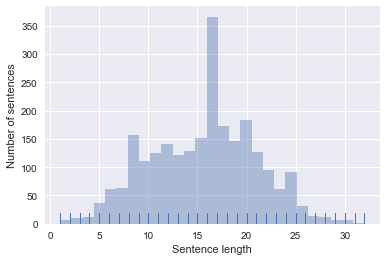

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
sns.distplot(sentence_lengths, kde=False, rug=True)

## 4 Modeling

### 4.1 Enbeddings with Bag of Words Model

Next step, we need to encode texts in order to feed them into algorithms. 

Bag of words is a model that simply count the number of each word in each sentence, and represent a sentence with 0 and 1. With this model, we will get a very sparse matrix with each row indicate each sentence and columns obtained from the words.

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def emb(data):
    count_vectorizer = CountVectorizer()
    embedding = count_vectorizer.fit_transform(data)
    return embedding, count_vectorizer


In [203]:
# encode the class lable into 1 and 0 
# Not related or irrelevant = 0 

data['label_binary'] = [0 if x == 'Not related or irrelevant' else 1 for x in data.label]
data.head()

,item_id,item,label,tokens,label_binary
0,'575735721744449536',cyclone pam hits new zealand dominion post h...,Other Useful Information,"[cyclone, pam, hits, new, zealand, dominion, p...",1
1,'575736033058406400',#cylonepam devastates #vanuatu regional disas...,Infrastructure and utilities,"[cylonepam, devastates, vanuatu, regional, dis...",1
2,'575736037986578433',rt usrId emergency response teams from austral...,Affected individuals,"[rt, usrId, emergency, response, teams, from, ...",1
3,'575736076087644160',vanuatu ‰ #rt cyclone pam lashes vanuatu wit...,Other Useful Information,"[vanuatu, rt, cyclone, pam, lashes, vanuatu, w...",1
4,'575736131817369601',aid agencies vanuatu conditions more challeng...,Other Useful Information,"[aid, agencies, vanuatu, conditions, more, cha...",1


In [204]:
# seperate train and test

x = data['item'].tolist()
y = data['label_binary'].tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

X_train_counts, count_vectorizer = emb(X_train)
X_test_counts = count_vectorizer.transform(X_test)

We'd like to visualy inspect this dataset by reducing the dimensionality. Here we apply latent semantic analysis(LSA) which perform linear dimensionality reduction. 

In [205]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

# reduce the dimensionality 
svd = TruncatedSVD(n_components=2)
svd.fit(X_train_counts)
lsa_scores = svd.transform(X_train_counts)
               
lsa_scores

array([[ 1.74854608, -0.98273917],
       [ 3.16633354,  0.5025912 ],
       [ 1.81532776, -0.9608788 ],
       ...,
       [ 2.72933314,  0.26141637],
       [ 1.87048046, -0.73578098],
       [ 1.39287886,  0.51326564]])

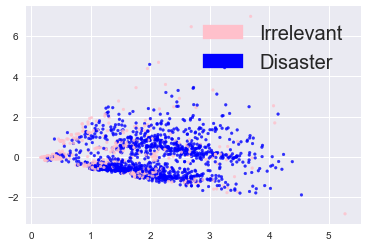

In [227]:
color_mapper = {label:idx for idx, label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['pink','blue']

plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

fig = plt.figure(figsize=(30, 30))          
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)


In [ ]:
def metrics_df(y_test, y_predicted):
        train_accuracy_score_list.append(metrics.accuracy_score(train_Y,train_predictions))
        test_accuracy_score_list.append(metrics.accuracy_score(test_Y,test_predictions))
        train_recall_score_list.append(metrics.recall_score(train_Y,train_predictions))
        test_recall_score_list.append(metrics.recall_score(test_Y,test_predictions))
        train_precision_score_list.append(metrics.precision_score(train_Y, train_predictions))
        test_precision_score_list.append(metrics.precision_score(test_Y, test_predictions))
        train_f1_score_list.append(metrics.f1_score(train_Y, train_predictions))
        test_f1_score_list.append(metrics.f1_score(test_Y, test_predictions))
        
        cm = metrics.confusion_matrix(test_Y,  test_predictions)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

## Reference:

1. http://crisisnlp.qcri.org/lrec2016/lrec2016.html
1. [Dataset Github](http://github.com/CrisisNLP/deep-learning-for-big-crisis-data)
3. [tweetNLP](http://www.ark.cs.cmu.edu/TweetNLP)